In [2]:
import torch

from torchvision.datasets import VisionDataset
from torchvision.transforms import ToTensor
import numpy as np
from PIL import Image
import os
import os.path
import sys
from torch import nn
import torchsummary

In [2]:
torch.cuda.is_available()

True

In [4]:
dataset_phase1 = DatasetFolder('/project/davidr/lidc_idri/npys/lanczos/8x8/', 
                               loader=lambda path: np.load(path),
                               extensions=('npy',),
                               transform=lambda x: torch.from_numpy(x))

In [5]:
def num_filters(phase, num_phases, base_dim):
    num_downscales = int(np.log2(base_dim / 16))
    filters = min(base_dim // (2 ** (phase - num_phases + num_downscales)), base_dim)
    return filters

In [6]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _single, _pair, _triple
import torch.nn.functional as F

In [7]:
from torch.nn import init

In [8]:
from torch.nn.init import calculate_gain, _calculate_correct_fan, _calculate_fan_in_and_fan_out

In [9]:
def kaiming_normal_(tensor, a=1e-2, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / np.sqrt(fan)
    with torch.no_grad():
        tensor.normal_(0, 1)
        return std

In [10]:
class ScaleLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, gain):
        super(ScaleLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        
        fan_in, _ = _calculate_fan_in_and_fan_out(self.weight)
        self.std = gain / np.sqrt(fan_in)
        
        print(self.std)

    def forward(self, input):
        return F.linear(input, self.weight * self.std, self.bias)


In [11]:
ScaleLinear(512, 1024, gain=np.sqrt(2))(torch.randn(1, 512))

0.0625


tensor([[-0.8857,  1.8443, -0.9034,  ...,  2.5443,  3.0866,  0.2855]],
       grad_fn=<AddmmBackward>)

In [12]:
class ScaleConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gain, stride=1,
                 padding=0):
        super(ScaleConv3d, self).__init__()
        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(
                out_channels, in_channels, *kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
                
        fan_in, _ = _calculate_fan_in_and_fan_out(self.weight)
        print(fan_in, self.weight.shape)
        self.std = gain / np.sqrt(fan_in)
        
        print(self.std)


    def forward(self, input):        
        return F.conv3d(input, self.weight * self.std, self.bias, self.stride,
                        self.padding)


In [13]:
ScaleConv3d(3, 32, 3, np.sqrt(2))(torch.randn(1, 3, 4, 4, 4))

81 torch.Size([32, 3, 3, 3, 3])
0.15713484026367724


tensor([[[[[-8.8279e-02,  1.1751e+00],
           [ 6.3511e-01, -1.3265e+00]],

          [[ 5.0024e-01,  6.9367e-01],
           [-2.5748e-01, -1.4162e+00]]],


         [[[ 3.2810e+00, -1.0235e+00],
           [-2.6426e+00, -3.1438e-01]],

          [[ 1.0964e+00,  1.2991e+00],
           [ 8.6524e-01,  4.7748e-01]]],


         [[[ 2.7181e+00,  6.4119e-01],
           [ 1.3985e+00, -4.0136e-01]],

          [[-6.1185e-01, -2.2857e+00],
           [ 5.5720e-01, -8.5121e-01]]],


         [[[-2.7544e-01, -1.0366e+00],
           [-6.2685e-01, -1.0289e+00]],

          [[ 5.9843e-01, -1.2806e+00],
           [ 6.5786e-01,  5.5595e-01]]],


         [[[-9.4004e-01, -1.2042e-01],
           [ 6.5157e-01, -9.4176e-01]],

          [[ 9.7319e-01, -3.0887e-02],
           [-1.0150e+00, -2.2692e+00]]],


         [[[-2.6934e-02,  2.5100e-01],
           [ 9.1471e-01,  8.0825e-01]],

          [[ 9.6768e-01, -9.8394e-01],
           [-1.1850e+00, -1.7409e+00]]],


         [[[-3.9369e-01,  2.

In [14]:
class DiscriminatorBlock(nn.Sequential):
    def __init__(self, filters_in, filters_out):
        super(DiscriminatorBlock, self).__init__()
        
        self.conv1 = ScaleConv3d(filters_in, filters_in, 3, padding=1, gain=np.sqrt(2))
        self.conv2 = ScaleConv3d(filters_in, filters_out, 3, padding=1, gain=np.sqrt(2))
        self.lrelu = nn.LeakyReLU()
        self.downsampling = nn.AvgPool3d(2)
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.lrelu(x)
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.downsampling(x)
        return x
        
        


In [15]:
class FromRGB(nn.Sequential):
    def __init__(self, filters):
        super(FromRGB, self).__init__()
        self.fromrgb = nn.Sequential(
            ScaleConv3d(1, filters, 3, padding=1, gain=np.sqrt(2)),
            nn.LeakyReLU()
        )
    
    def forward(self, input):
        return self.fromrgb(input)


In [20]:
class MinibatchStandardDeviation(nn.Module):
    def __init__(self, group_size=4):
        super(MinibatchStandardDeviation, self).__init__()
        self.group_size = group_size
        
    def forward(self, input):
        group_size = min(self.group_size, input.shape[0])
        if group_size < len(input):
            for i in range(group_size, len(input) + 1):
                if len(input) % i == 0:
                    group_size = i
                    break
        
        s = input.shape
        y = input.view([group_size, -1, s[1], s[2], s[3], s[4]])
        y -= torch.mean(y, dim=0, keepdim=True)                     
        y = torch.mean(y ** 2, dim=0)                           
        y = torch.sqrt(y + 1e-8)
        y = torch.mean(y, dim=[1, 2, 3, 4], keepdim=True)
        y = y.repeat([group_size, 1, s[2], s[3], s[4]])
        return torch.cat([input, y], dim=1)                            


In [21]:
MinibatchStandardDeviation()(torch.randn(21, 256, 2, 8, 8)).shape

torch.Size([21, 257, 2, 8, 8])

In [22]:
class Discriminator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Discriminator, self).__init__()
        filters_out = num_filters(phase, num_phases, base_dim)
        self.phase = phase
        self.fromrgb = FromRGB(filters_out)
        self.blocks = nn.ModuleDict()
        self.fromrgbs = nn.ModuleDict()
        for i in reversed(range(1, phase)):
            filters_in = num_filters(i + 1, num_phases, base_dim)
            filters_out = num_filters(i, num_phases, base_dim)
            self.blocks[f'discriminator_block_{i + 1}'] = DiscriminatorBlock(filters_in, filters_out)
            self.fromrgbs[f'from_rgb_{i}'] = FromRGB(filters_out)
            
        self.downscale = nn.AvgPool3d(2)
            
        print(np.product(base_shape) * base_dim)
        self.discriminator_out = nn.Sequential(
            MinibatchStandardDeviation(),
            ScaleConv3d(filters_out + 1, base_dim, 3, padding=1, gain=np.sqrt(2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            ScaleLinear(np.product(base_shape) * base_dim, latent_dim, gain=np.sqrt(2)),
            nn.LeakyReLU(),
            ScaleLinear(latent_dim, 1, gain=1)
        )
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, input, alpha=0):
        
        input = input.to(self.device)
        
        x_downscale = input.clone()
        
        x = self.fromrgb(input)
                                
        for i in reversed(range(1, self.phase)):
            x = self.blocks[f'discriminator_block_{i + 1}'](x)
            
            x_downscale = self.downscale(x_downscale)
            fromrgb_prev = self.fromrgbs[f'from_rgb_{i}'](x_downscale)
            x = alpha * fromrgb_prev + (1 - alpha) * x
            
        x = self.discriminator_out(x)
        return x
            
        
            
        

In [23]:
torch.cuda.is_available()

True

In [24]:
phase = 5
size = 2 * 2 ** phase

In [25]:
d = Discriminator(phase, 8, 256, 256, (1, 4, 4))

27 torch.Size([128, 1, 3, 3, 3])
0.2721655269759087
3456 torch.Size([128, 128, 3, 3, 3])
0.024056261216234408
3456 torch.Size([256, 128, 3, 3, 3])
0.024056261216234408
27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
4096
6939 torch.Size([256, 257, 3, 3, 3])
0.01697721912327874
0.02209708691207961
0.0625


In [26]:
x = torch.randn(1, 1, size // 4, size, size).to(d.device)

In [27]:
d(x, 0.5).shape

torch.Size([1, 1])

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [29]:
count_parameters(d)

14803841

In [30]:
class ChannelNormalization(nn.Module):
    def __init__(self):
        super(ChannelNormalization, self).__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=-1, keepdim=True) + 1e-8)


In [31]:
class GeneratorBlock(nn.Sequential):
    def __init__(self, filters_in, filters_out):
        super(GeneratorBlock, self).__init__()
        self.upsampling = nn.Upsample(scale_factor=2)
        self.conv1 = ScaleConv3d(filters_in, filters_out, 3, padding=1, gain=np.sqrt(2))
        self.conv2 = ScaleConv3d(filters_out, filters_out, 3, padding=1, gain=np.sqrt(2))
        self.lrelu = nn.LeakyReLU()
        self.cn = ChannelNormalization()
    
    def forward(self, input):
        x = self.upsampling(input)
        x = self.conv1(x)
        x = self.lrelu(x)
        x = self.cn(x)
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.cn(x)
        return x
        
        


In [32]:
class ToRGB(nn.Sequential):
    def __init__(self, filters_in, channels=1):
        super(ToRGB, self).__init__()
        self.conv = ScaleConv3d(filters_in, channels, 3, padding=1, gain=1)
        
    def forward(self, input):
        return self.conv(input)

In [33]:
torgb = ToRGB(256)

6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204


In [34]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, input):
        return torch.reshape(input, self.shape)

In [35]:
class Generator(nn.Module):
    def __init__(self, phase, num_phases, base_dim, latent_dim, base_shape):
        super(Generator, self).__init__()
        self.phase = phase
        self.latent_dim = latent_dim
        filters = base_dim
        self.generator_in = nn.Sequential(
            ScaleLinear(latent_dim, np.product(base_shape) * filters, gain=np.sqrt(2) / 4),
            nn.LeakyReLU(),
            Reshape([-1, filters] + list(base_shape)),
            ScaleConv3d(filters, filters, 3, padding=1, gain=np.sqrt(2)),
            nn.LeakyReLU(),
            ChannelNormalization()
        )
        
        self.to_rgb_1 = ToRGB(filters)
        
        self.blocks = nn.ModuleDict()
        self.to_rgbs = nn.ModuleDict()
        
        for i in range(1, phase):
            filters_in = num_filters(i, num_phases, base_dim)
            filters_out = num_filters(i + 1, num_phases, base_dim)
            self.blocks[f'generator_block_{i + 1}'] = GeneratorBlock(filters_in, filters_out)
            self.to_rgbs[f'to_rgb_{i + 1}'] = ToRGB(filters_out)
            
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
            
    
    def forward(self, input, alpha=0):
        input = input.to(self.device)
        
        x = self.generator_in(input)
        
        images_out = self.to_rgb_1(x)
        
        for i in range(1, self.phase):
            x = self.blocks[f'generator_block_{i + 1}'](x)
            img_gen = self.to_rgbs[f'to_rgb_{i + 1}'](x)
            images_out = alpha * (self.upsample(images_out)) + (1 - alpha) * img_gen
        
        return images_out

In [36]:
g = Generator(5, 8, 256, 256, (1, 4, 4))

0.02209708691207961
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204
6912 torch.Size([128, 256, 3, 3, 3])
0.017010345435994292
3456 torch.Size([128, 128, 3, 3, 3])
0.024056261216234408
3456 torch.Size([1, 128, 3, 3, 3])
0.017010345435994292


In [37]:
x = torch.randn(1, 256).to(g.device)

In [38]:
count_parameters(g)

14799237

In [70]:
discriminator = Discriminator(2, 8, 256, 256, (1, 4, 4))
generator = Generator(2, 8, 256, 256, (1, 4, 4))

27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
27 torch.Size([256, 1, 3, 3, 3])
0.2721655269759087
4096
6939 torch.Size([256, 257, 3, 3, 3])
0.01697721912327874
0.02209708691207961
0.0625
0.02209708691207961
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([256, 256, 3, 3, 3])
0.017010345435994292
6912 torch.Size([1, 256, 3, 3, 3])
0.012028130608117204


In [71]:
d_optim = torch.optim.Adam(discriminator.parameters(), betas=(0, 0.9))
g_optim = torch.optim.Adam(generator.parameters(), betas=(0, 0.9))

In [72]:
data_loader = torch.utils.data.DataLoader(dataset_phase1, batch_size=64)

In [73]:
def wasserstein_loss(y_pred):
    return y_pred.mean()

In [74]:
def gradient_penalty_loss(y_pred, 
                          averaged_samples,
                          gradient_penalty_weight=10):
    
    grad_outputs = torch.ones_like(y_pred).to(y_pred.device)
    gradients = torch.autograd.grad(
        y_pred, 
        inputs=averaged_samples,
        grad_outputs=grad_outputs,
        create_graph=True, 
        retain_graph=True)[0]
    
    gradients_sqr = gradients ** 2
    gradients_sqr_sum = torch.sum(gradients_sqr, 
                                  dim=tuple(range(1, len(gradients_sqr.shape))))
    gradient_l2_norm = torch.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * (1 - gradient_l2_norm) ** 2
    return torch.mean(gradient_penalty)


In [75]:
def random_weighted_average(tensor_a, tensor_b):
    weights = torch.rand_like(tensor_a).to(tensor_a.device)
    return weights * tensor_a + (1 - weights) * tensor_b

In [76]:
import matplotlib.pyplot as plt

In [77]:
def train_epoch(data_loader, generator, discriminator, generator_optim, discriminator_optim, alpha):
    
    d_losses = []
    g_losses = []
    
    for i, x_real in enumerate(data_loader):
        
        # Train discriminator.
        generator.eval()
        discriminator.train()
        
        x_real = x_real.to(discriminator.device)
        z = torch.randn(x_real.shape[0], generator.latent_dim)
        x_fake = generator(z, alpha)
        
        d_real = discriminator(x_real, alpha)
        d_fake = discriminator(x_fake, alpha)
        
        averaged_samples = torch.autograd.Variable(random_weighted_average(x_fake, x_real),
                                          requires_grad=True)
        d_avg = discriminator(averaged_samples, alpha)
        
        gp_loss = gradient_penalty_loss(d_avg, averaged_samples)
        real_loss = wasserstein_loss(d_real)
        fake_loss = wasserstein_loss(d_fake)
        
        d_loss = real_loss - fake_loss + gp_loss
        
        discriminator_optim.zero_grad()
        d_loss.backward()
        discriminator_optim.step()
        
        d_losses.append(d_loss.item())
        
        # Train generator.
        generator.train()
        discriminator.eval()
        
        z = torch.randn(x_real.shape[0], generator.latent_dim)
        x_fake = generator(z)
        d_fake = discriminator(x_fake)
        g_loss = wasserstein_loss(d_fake)
        
        generator_optim.zero_grad()
        g_loss.backward()
        generator_optim.step()
        
        g_losses.append(g_loss.item())
        
        if i % 50 == 0:
            print(g_loss.item(), d_loss.item())
           
    print("Real")
    print(x_real.shape)
    plt.imshow(x_real[0, 0, 0].squeeze().cpu().detach().numpy())
    plt.show()

    print("Fake")
    plt.imshow(x_fake[0, 0, 0].squeeze().cpu().detach().numpy())
    plt.show()          
    return np.mean(d_losses), np.mean(g_losses)
        

0.0017818266060203314 8.892388343811035
Real
torch.Size([34, 1, 2, 8, 8])


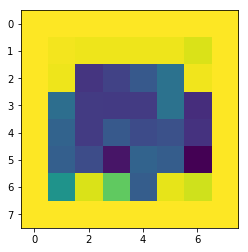

Fake


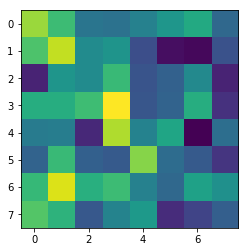

0.08140793442726135 7.318933963775635
Real
torch.Size([34, 1, 2, 8, 8])


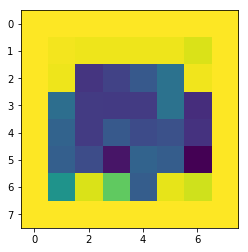

Fake


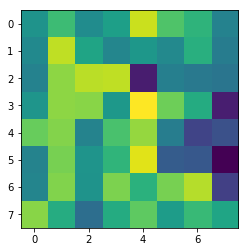

0.1950497329235077 4.440647602081299
Real
torch.Size([34, 1, 2, 8, 8])


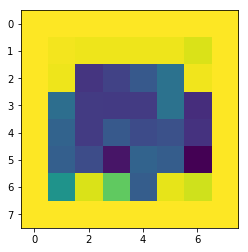

Fake


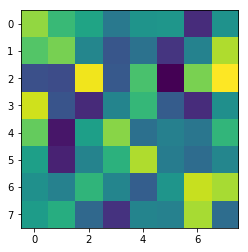

0.239976704120636 1.5599300861358643
Real
torch.Size([34, 1, 2, 8, 8])


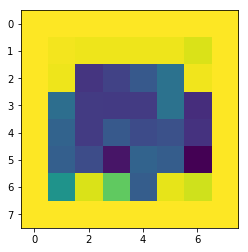

Fake


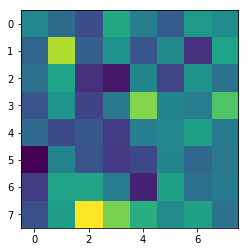

0.20331193506717682 -0.7265087366104126
Real
torch.Size([34, 1, 2, 8, 8])


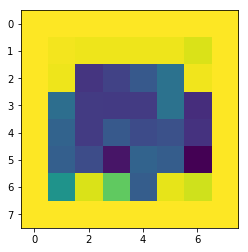

Fake


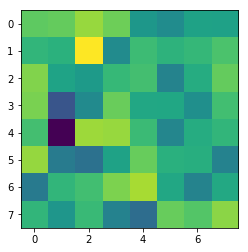

0.12479601055383682 -2.388756275177002
Real
torch.Size([34, 1, 2, 8, 8])


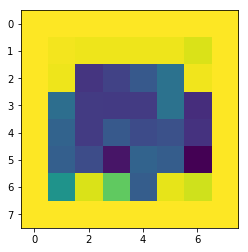

Fake


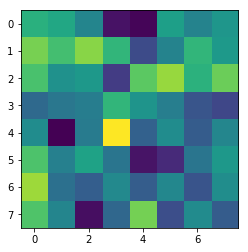

0.034225814044475555 -3.0308454036712646
Real
torch.Size([34, 1, 2, 8, 8])


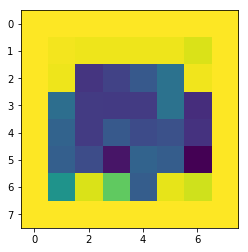

Fake


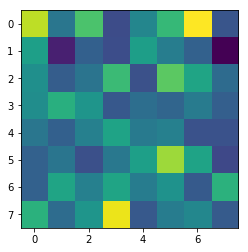

-0.036842793226242065 -3.3236446380615234
Real
torch.Size([34, 1, 2, 8, 8])


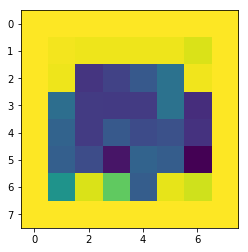

Fake


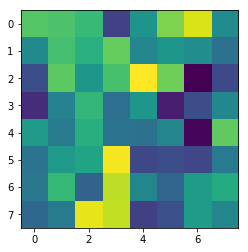

-0.13059735298156738 -3.486013412475586
Real
torch.Size([34, 1, 2, 8, 8])


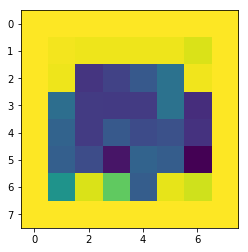

Fake


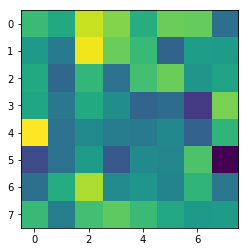

-0.25104469060897827 -4.194472312927246
Real
torch.Size([34, 1, 2, 8, 8])


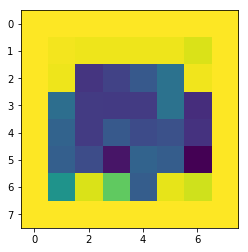

Fake


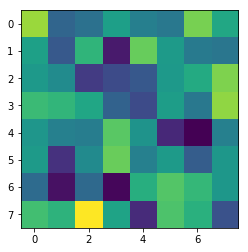

-0.4084758758544922 -4.4303765296936035
Real
torch.Size([34, 1, 2, 8, 8])


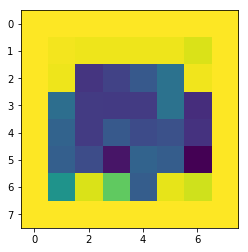

Fake


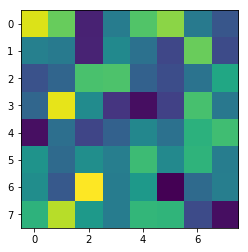

-0.5607630014419556 -5.019156455993652
Real
torch.Size([34, 1, 2, 8, 8])


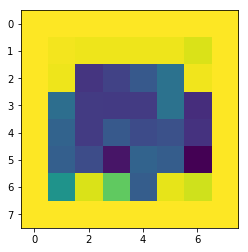

Fake


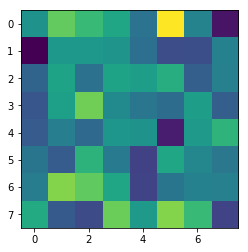

-0.7132313847541809 -5.079145431518555
Real
torch.Size([34, 1, 2, 8, 8])


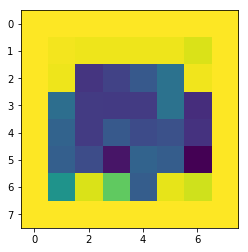

Fake


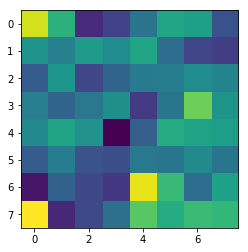

-0.851354718208313 -5.472722053527832
Real
torch.Size([34, 1, 2, 8, 8])


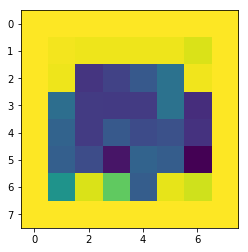

Fake


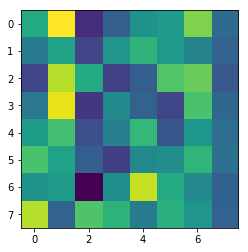

-0.9721331596374512 -5.47064208984375
Real
torch.Size([34, 1, 2, 8, 8])


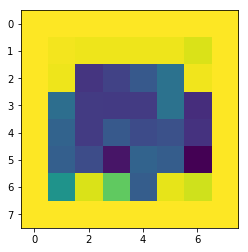

Fake


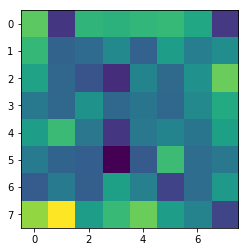

-1.0599745512008667 -5.6551289558410645
Real
torch.Size([34, 1, 2, 8, 8])


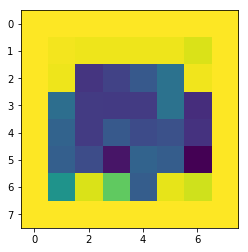

Fake


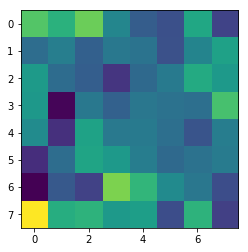

-1.1391912698745728 -5.916126251220703
Real
torch.Size([34, 1, 2, 8, 8])


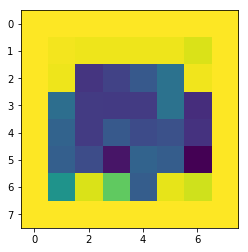

Fake


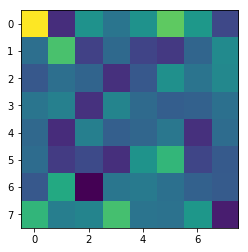

-1.1636556386947632 -6.173571586608887
Real
torch.Size([34, 1, 2, 8, 8])


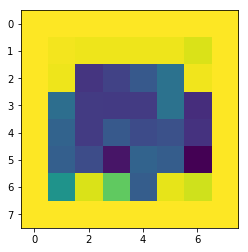

Fake


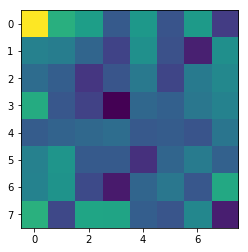

-1.1891919374465942 -6.355695724487305
Real
torch.Size([34, 1, 2, 8, 8])


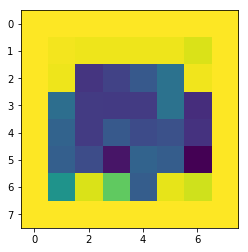

Fake


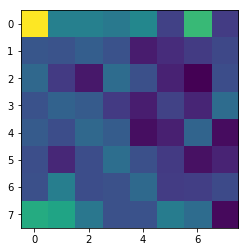

-1.2015483379364014 -6.147730827331543
Real
torch.Size([34, 1, 2, 8, 8])


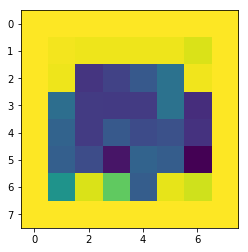

Fake


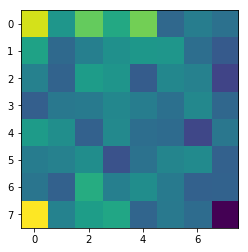

-1.2276620864868164 -6.607223987579346
Real
torch.Size([34, 1, 2, 8, 8])


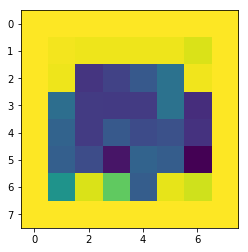

Fake


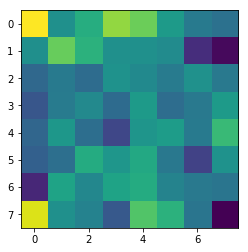

-1.2554293870925903 -6.57717227935791
Real
torch.Size([34, 1, 2, 8, 8])


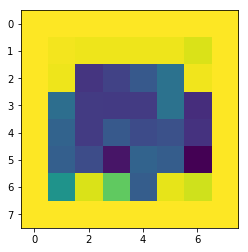

Fake


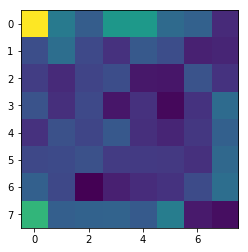

-1.3189319372177124 -6.519834518432617
Real
torch.Size([34, 1, 2, 8, 8])


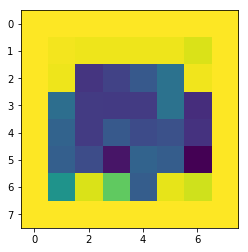

Fake


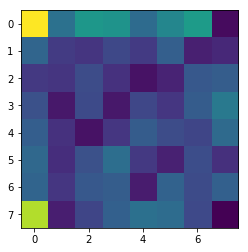

-1.366519570350647 -6.922039031982422
Real
torch.Size([34, 1, 2, 8, 8])


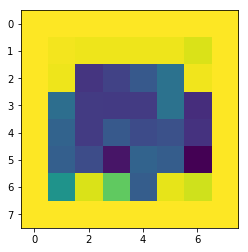

Fake


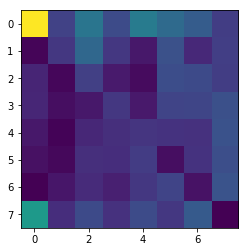

-1.4195430278778076 -6.561422348022461
Real
torch.Size([34, 1, 2, 8, 8])


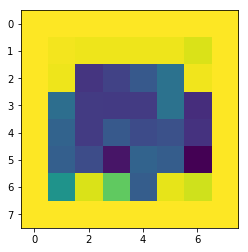

Fake


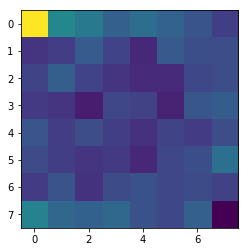

-1.4773496389389038 -6.8926286697387695
Real
torch.Size([34, 1, 2, 8, 8])


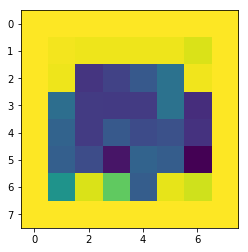

Fake


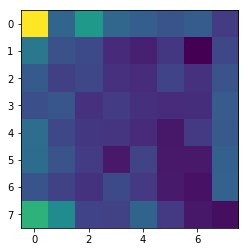

-1.5169609785079956 -6.880873680114746
Real
torch.Size([34, 1, 2, 8, 8])


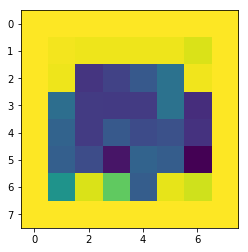

Fake


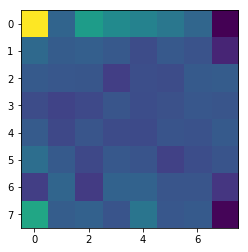

-1.5601692199707031 -6.977299690246582
Real
torch.Size([34, 1, 2, 8, 8])


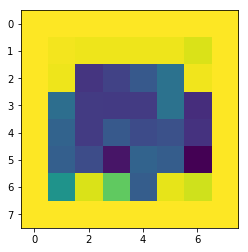

Fake


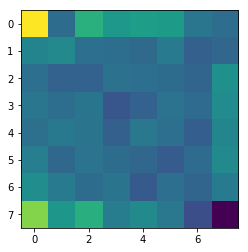

-1.5662776231765747 -6.663258075714111
Real
torch.Size([34, 1, 2, 8, 8])


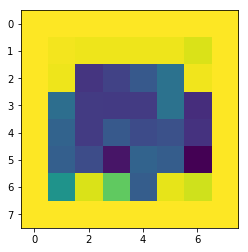

Fake


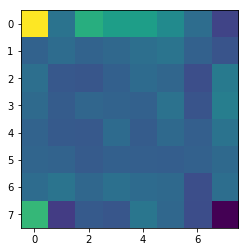

-1.6043572425842285 -6.8117265701293945
Real
torch.Size([34, 1, 2, 8, 8])


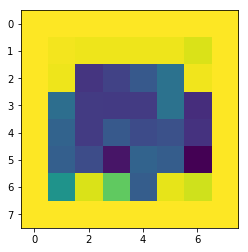

Fake


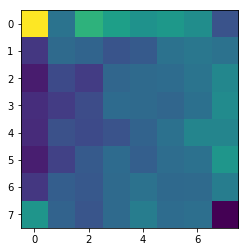

-1.6151378154754639 -6.638369560241699
Real
torch.Size([34, 1, 2, 8, 8])


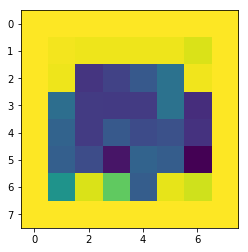

Fake


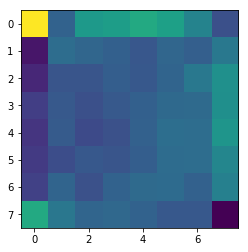

-1.6186561584472656 -6.810827732086182
Real
torch.Size([34, 1, 2, 8, 8])


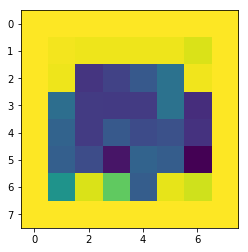

Fake


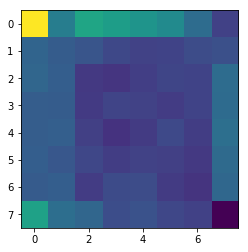

-1.5873479843139648 -7.053680419921875
Real
torch.Size([34, 1, 2, 8, 8])


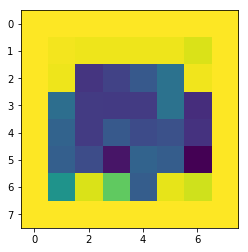

Fake


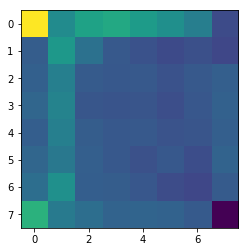

-1.5436718463897705 -7.129299640655518
Real
torch.Size([34, 1, 2, 8, 8])


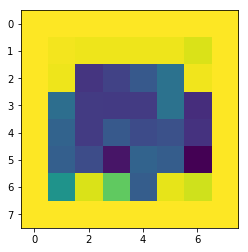

Fake


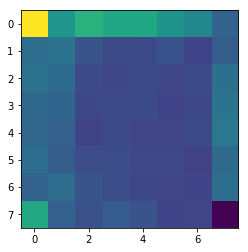

-1.4744226932525635 -7.309231758117676
Real
torch.Size([34, 1, 2, 8, 8])


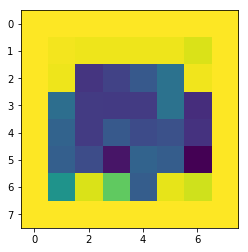

Fake


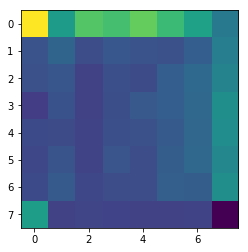

-1.4740307331085205 -7.121729373931885
Real
torch.Size([34, 1, 2, 8, 8])


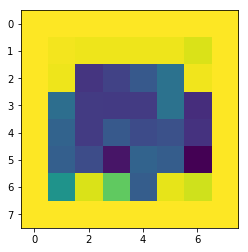

Fake


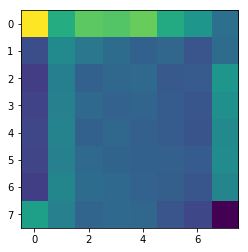

-1.42765474319458 -7.686453819274902
Real
torch.Size([34, 1, 2, 8, 8])


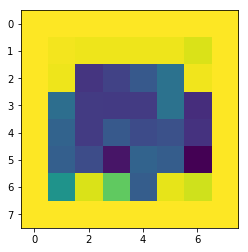

Fake


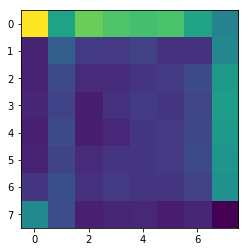

-1.373172402381897 -6.866070747375488
Real
torch.Size([34, 1, 2, 8, 8])


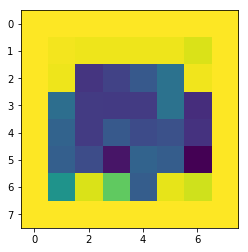

Fake


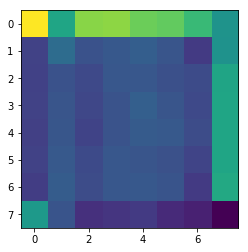

-1.2902631759643555 -7.158987998962402
Real
torch.Size([34, 1, 2, 8, 8])


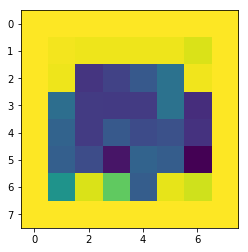

Fake


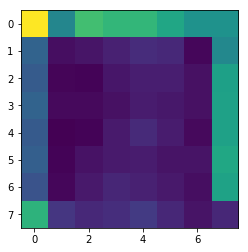

-1.2051665782928467 -8.292360305786133
Real
torch.Size([34, 1, 2, 8, 8])


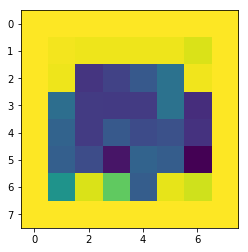

Fake


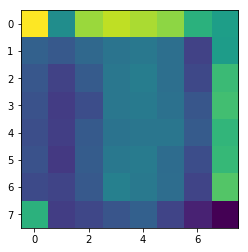

-1.1493220329284668 -7.596035480499268
Real
torch.Size([34, 1, 2, 8, 8])


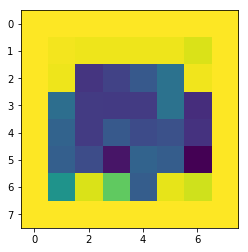

Fake


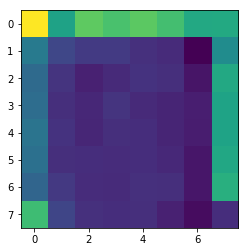

-0.9988689422607422 -7.283074378967285
Real
torch.Size([34, 1, 2, 8, 8])


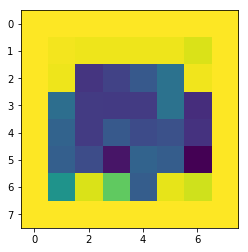

Fake


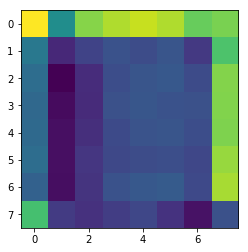

-0.8932740688323975 -7.781860828399658
Real
torch.Size([34, 1, 2, 8, 8])


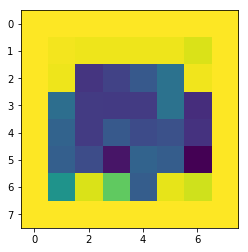

Fake


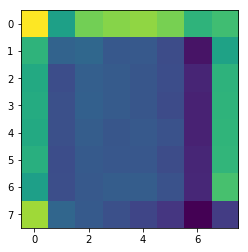

-0.7638353109359741 -8.301698684692383


In [ ]:
for _ in range(256):
    train_epoch(data_loader, generator, discriminator, generator_optim=g_optim, 
            discriminator_optim=d_optim, alpha=1)

In [5]:
for i in range(100):
    x = np.random.randn(1, 1, 32, 32, 32)
    np.save(f'test_{i}.npy', x)
    x = torch.from_numpy(x)
    torch.save(x, f'test_{i}.pt')

In [7]:
%timeit for i in range(100): torch.from_numpy(np.load(f'test_{i}.npy'))

121 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit for i in range(100): torch.load(f'test_{i}.pt')

85.9 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
!rm *.npy

In [12]:
!ls

convert_to_numpy.py  pgan_pytorch		test_0.gif  test_5.gif
convert_to_torch.py  process_lidc_idri_data.py	test_1.gif  test_6.gif
extract_metadata.py  README.md			test_2.gif  wgan_gp
metadata.csv	     stylegan			test_3.gif
pgan		     stylegan_3d		test_4.gif
